# Attention mechanism for sentiment analysis


In this lab we use part of the 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle. The dataset contain the following information:

- Product Name
- Brand Name
- Price
- Rating
- Reviews
- Review Votes

We are mainly interested by the 'Reviews' (X) and by the 'Rating' (y)

The goal is to try to predict the 'Rating' after reading the 'Reviews'. I've prepared for you TRAIN and TEST set.
The work to be done is as follows:

1. Feature extraction and baseline
   - read the dataset and understand it
   - put it in a format so that you can use `CountVectorizer` or`Tf-IDF` to extract the desired features
   - perform on the desired dates and preprocessing
   - use one of the classifiers you know to predict the polarity of different sentences
1. My first neural network
   - reuse the features already extracted
   - proposed a neural network built with Keras
1. Hyper-parameter fitting
   - for the base line: adjust min_df, max_df, ngram, max_features + model's hyper-parameter
   - for the neural network: adjust batch size, number of layers and number of neuron by layers, use earlystop
1. <span style="color:red">Word embedding
   - stage 1 build a network that uses Keras' embedding which is not language sensitive.
   - stage 2 build a network that simultaneously uses Keras' embedding and the features extracted in the first weeks.
   - stage 3 try to use an existing embedding (https://github.com/facebookresearch/MUSE)
     </span>

**WARNING:** the dataset is voluminous, I can only encourage you to work first on a small part of it and only at the end, when the code is well debugged and that it is necessary to build the "final model", to use the whole dataset.


In [19]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (LSTM, Activation, AveragePooling1D,
                                     Bidirectional, Dense, Dot, Dropout,
                                     Embedding, Flatten, Input, Permute,
                                     RepeatVector, TextVectorization,
                                     TimeDistributed)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import plot_model
from tensorflow_addons.metrics import F1Score


## Read the dataset

Could you find below a proposal. You can complete them.


In [3]:
BASE_DATASET_PATH = "http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/"
TRAIN = pd.read_csv(f"{BASE_DATASET_PATH}train.csv.gz").fillna(value="")
VAL = pd.read_csv(f"{BASE_DATASET_PATH}val.csv.gz").fillna(value="")
TEST = pd.read_csv(f"{BASE_DATASET_PATH}test.csv.gz").fillna(value="")

TRAIN = TRAIN[:2042]  # save training time, remove later


TRAIN.head()


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.0,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


In [4]:
""" Construct X_train and y_train """
X_train = np.array(TRAIN["Reviews"]).reshape(-1, 1)

ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
y_train = ohe.fit_transform(np.array(TRAIN["Rating"]).reshape(-1, 1))

X_train.shape, y_train.shape


((2042, 1), (2042, 5))

In [5]:
""" Do the same for val """
X_val = np.array(VAL["Reviews"]).reshape(-1, 1)
y_val = ohe.transform(np.array(VAL["Rating"]).reshape(-1, 1))

""" Do the same for test """
X_test = np.array(TEST["Reviews"]).reshape(-1, 1)
y_test = ohe.transform(np.array(TEST["Rating"]).reshape(-1, 1))


In [6]:
X_train.shape, X_test.shape, X_val.shape


((2042, 1), (1000, 1), (1000, 1))

## Build an a neural network with vectorized embedding and RNN cells.

The task is to predict the sentiment according to the content of the review. We can treat this kind of task by a Many-to-one model.

![LSTM for sentiment analysis](https://www.programmerall.com/images/679/8c/8c66e6ee3b9418358a791b363572bedf.jpeg)

Implement such a network with :

- a first layer of type LSTM
- a second layer of type LSTM, each cell of this layer will be fed by the corresponding output of the first layer (see figure above).


### Study of the size of the reviews.

In [7]:
import plotly.express as px

px.histogram(
    data_frame={"review_length": [len(review[0].split(" ")) for review in X_train]},
    cumulative=True,
    histnorm="probability density",
    title="Cumulative histogram of the review lengths (in number of words)"
)


We simply spitted the reviews by white space, which is a simple, basic approach, but yet informative. The plot above tells us that in order to get $95\%$ of the reviews that are non-truncated, we could consider the `max_len` parameter to be 150.

In [8]:
# Constants
nb_classes = y_train.shape[1]
vocab_size = 10 ** 4  # Maximum vocab size -- adjust with the size of the vocabulary
embedding_size = 20  # Embedding size (usually <= 300)
recurrent_size = 64  # Recurrent size
hidden_size = recurrent_size // 4  # Hidden layer
dropout_rate = 0.2  # Dropout rate for regularization (usually between 0.1 and 0.25)
max_len = 150  # Sequence length to pad the outputs to (deduced from the length distribution study)
learning_rate = 0.0075


In [9]:
# Create the vectorized layer.
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize="lower_and_strip_punctuation",
    # it is possible to build your own function
    # to transform emoji into text
    # to transform foreign reviews in english one
    # etc.
    output_mode="int",
    output_sequence_length=max_len,
)


2022-02-10 11:41:07.337030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 11:41:07.374295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-02-10 11:41:07.374317: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-10 11:41:07.374938: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [10]:
# Fit vectorized layer on train
vectorize_layer.adapt(X_train)


In [11]:
# Define the network
def build_model():
    input_ = Input(shape=(1,), dtype=tf.string)
    x = vectorize_layer(input_)
    x = Embedding(vocab_size, embedding_size, name="Embedding")(x)
    x = Bidirectional(
        LSTM(
            recurrent_size,
            return_sequences=False,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate,
        )
    )(x)
    x = Dense(hidden_size, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output_ = Dense(nb_classes, activation="softmax", dtype=tf.float64)(x)
    model = Model(input_, output_)
    return model


model = build_model()


In [13]:
# summarize the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 Embedding (Embedding)       (None, 150, 20)           200000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              43520     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0     

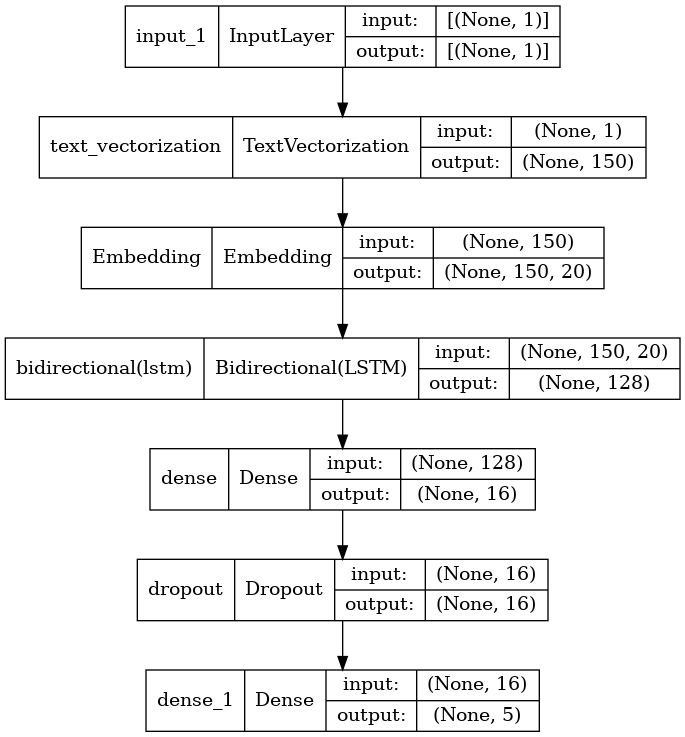

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file="05-plot-model.png")


In [15]:
# Compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=None)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss="categorical_crossentropy", metrics=[f1])


In [16]:
# fit model using ealy stopping
es = EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=4000,
    callbacks=[es],
    verbose=1,
)


Epoch 1/4000
64/64 [==============================] - 16s 181ms/step - loss: 1.3270 - f1_score: 0.1848 - val_loss: 1.1170 - val_f1_score: 0.2338
Epoch 2/4000
64/64 [==============================] - 12s 186ms/step - loss: 1.0309 - f1_score: 0.2837 - val_loss: 1.0392 - val_f1_score: 0.2696
Epoch 3/4000
64/64 [==============================] - 16s 248ms/step - loss: 0.8816 - f1_score: 0.2999 - val_loss: 1.0056 - val_f1_score: 0.2745
Epoch 4/4000
64/64 [==============================] - 17s 260ms/step - loss: 0.7596 - f1_score: 0.3348 - val_loss: 1.0555 - val_f1_score: 0.2979
Epoch 5/4000
64/64 [==============================] - 14s 217ms/step - loss: 0.6757 - f1_score: 0.3749 - val_loss: 1.1245 - val_f1_score: 0.3183
Epoch 6/4000
64/64 [==============================] - 14s 219ms/step - loss: 0.6178 - f1_score: 0.5033 - val_loss: 1.1893 - val_f1_score: 0.3293
Epoch 7/4000
64/64 [==============================] - 14s 224ms/step - loss: 0.5552 - f1_score: 0.5338 - val_loss: 1.2859 - val_f1

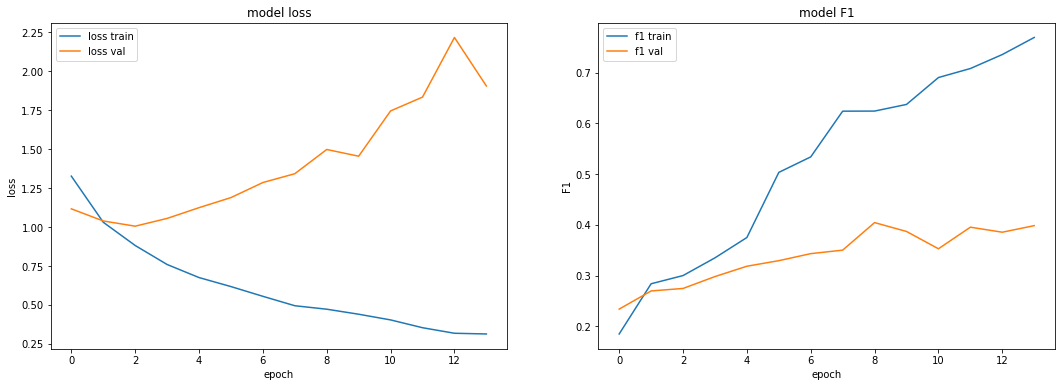

In [17]:
# plot history
def babysit(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # summarize history for loss
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.set_title("model loss")
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")
    ax1.legend(["loss train", "loss val"], loc="best")

    # summarize history for loss
    ax2.plot(history.history["f1_score"])
    ax2.plot(history.history["val_f1_score"])
    ax2.set_title("model F1")
    ax2.set_ylabel("F1")
    ax2.set_xlabel("epoch")
    ax2.legend(["f1 train", "f1 val"], loc="best")

    plt.show()


babysit(history)


In [18]:
# Evaluate the model
f1.update_state(y_test, model.predict(X_test))
print(f"F1: {f1.result().numpy()}")


F1: 0.3929598033428192


<font color='red'>
To do student

1. Understand the code
1. Play with LSTM model for sentiment analysis
   - Replace LSTM by BI-LSTM
   - Use stacked LSTM or BI-LSTM \* Use all hidden state and average it
   </font>


<font color='green'>
If you want to go further

If you are interested in the subject, current networks for sentiment prediction combine a part with recurrent networks (LTSM) to capture long dependencies and a part with convolution (CNN) to capture short dependencies. [This resarch paper](https://arxiv.org/pdf/1904.04206.pdf) or [this one](https://hal.archives-ouvertes.fr/hal-03052803/document) describe some accurate networks for sentiment analysis.

Here, another paper that gives you some indications to go further: [Attention, CNN and what not for Text Classification](https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/)

You will see next week the CNN with Diane. So there is no need to use them today.
</font>


## Attention with LSTM network


In [ ]:
# ------------------------------------------------------
# MODEL BUILDING
# ------------------------------------------------------
def build_model():
    # Input: a review
    input_ = Input(shape=(1,), name="input", dtype=tf.string)

    # Transform the review in a list of tokenID
    vect = vectorize_layer(input_)

    # Keras embedding
    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_size,
        weights=None,  # Without pre-learning
        trainable=True,  # Trainable
        name="embedding",
    )(vect)

    # You can try also a Bidirectionnel cell
    rnn = LSTM(
        recurrent_size,
        return_sequences=True,
        return_state=False,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
    )(embedding)

    # In the case of LSTM, there are two internal states
    #      the hidden state, usually denoted by h,
    #      the cell state usually denoted by c
    # The tuple (c, h) is the internal state of a LSTM
    # return_sequences=True gives you the hidden state (h) of the LSTM for every timestep
    # used in combination with return_state=True, you will only get the tuple (c, h) for the final timestep

    # Attention layer
    attention = Dense(1, activation="tanh")(rnn)
    attention = Flatten()(attention)
    attention = Activation("softmax")(attention)

    # Pour pouvoir faire la multiplication (scalair/vecteur KERAS)
    attention = RepeatVector(recurrent_size)(attention)  # NORMAL RNN
    attention = Permute([2, 1])(attention)

    # Application de l'attention sur la sortie du RNN
    sent_representation = Dot(axes=1, normalize=False)([rnn, attention])

    # Flatten pour entrer dans le Dense
    flatten = Flatten()(sent_representation)

    # Dense pour la classification avec 1 couche cachee
    hidden_dense = Dense(hidden_size, activation="relu")(flatten)
    hidden_dense = Dropout(dropout_rate)(hidden_dense)

    # Classification et ouput
    output_ = Dense(nb_classes, activation="softmax")(hidden_dense)

    # Build  model
    model = Model(inputs=input_, outputs=output_)

    return model


model = build_model()


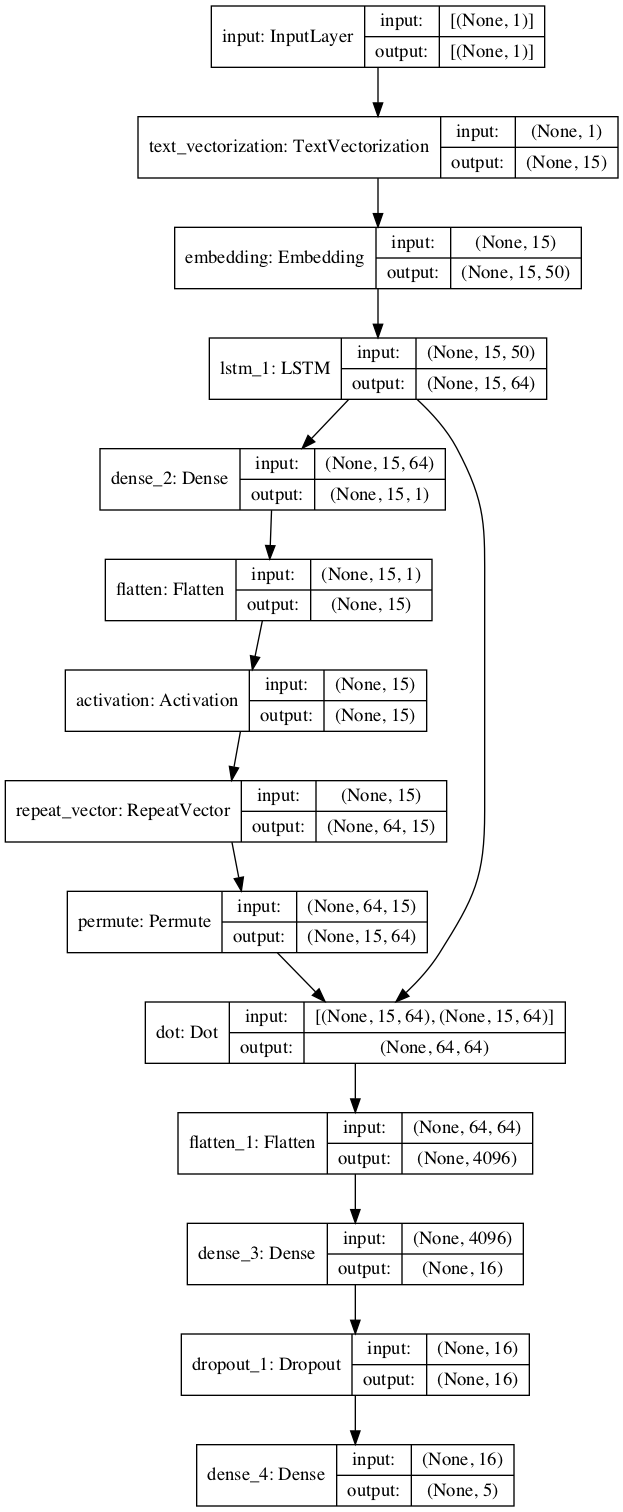

In [ ]:
# Plot model
plot_model(
    model, show_shapes=True, show_layer_names=True, to_file="LSTM_with_attention.png"
)


In [ ]:
# Compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=0.5)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss="categorical_crossentropy", metrics=[f1])


In [ ]:
# fit model using ealy stopping
es = EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=2,
)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4000,
    callbacks=[es],
    verbose=1,
)


Epoch 1/4000
157/157 [==============================] - 10s 37ms/step - loss: 1.2535 - f1_score: 0.1272 - val_loss: 1.1666 - val_f1_score: 0.1339
Epoch 2/4000
157/157 [==============================] - 5s 33ms/step - loss: 1.2004 - f1_score: 0.1380 - val_loss: 1.1692 - val_f1_score: 0.1375
Epoch 3/4000
157/157 [==============================] - 4s 29ms/step - loss: 1.1927 - f1_score: 0.1381 - val_loss: 1.1570 - val_f1_score: 0.1364
Epoch 4/4000
157/157 [==============================] - 5s 30ms/step - loss: 1.1887 - f1_score: 0.1369 - val_loss: 1.1566 - val_f1_score: 0.1455
Epoch 5/4000
157/157 [==============================] - 6s 39ms/step - loss: 1.1801 - f1_score: 0.1388 - val_loss: 1.1678 - val_f1_score: 0.1274
Epoch 6/4000
157/157 [==============================] - 6s 35ms/step - loss: 1.1815 - f1_score: 0.1371 - val_loss: 1.1487 - val_f1_score: 0.1453
Epoch 7/4000
157/157 [==============================] - 5s 32ms/step - loss: 1.1742 - f1_score: 0.1382 - val_loss: 1.1445 - val_f

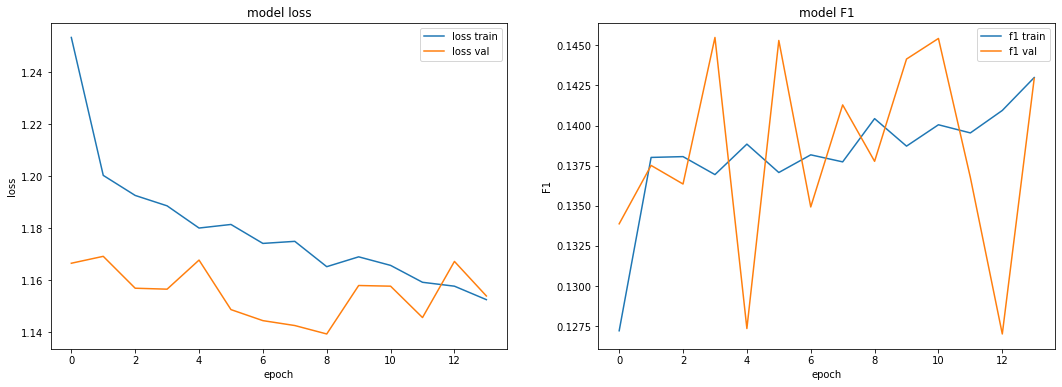

In [ ]:
# plot history
babysit(history)


In [ ]:
# Evaluate the model
f1.update_state(y_test, model.predict(X_test))
print("F1: %f" % (f1.result().numpy()))


F1: 0.147018


## Use Attentionnal model


In [ ]:
# ------------------------------------------------------
# GET ATTENTION MODEL
# ------------------------------------------------------
def get_attention_model(model):
    attention_layer_indice = 0
    for layer in model.layers:
        print(type(layer))
        if type(layer) is Activation:
            break
        else:
            attention_layer_indice += 1

    # Create an attention model
    return Model(
        inputs=model.layers[0].input,
        outputs=model.layers[attention_layer_indice].output,
    )


<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.preprocessing.text_vectorization.TextVectorization'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.recurrent_v2.LSTM'>
<class 'keras.layers.core.Dense'>
<class 'keras.layers.core.Flatten'>
<class 'keras.layers.core.Activation'>


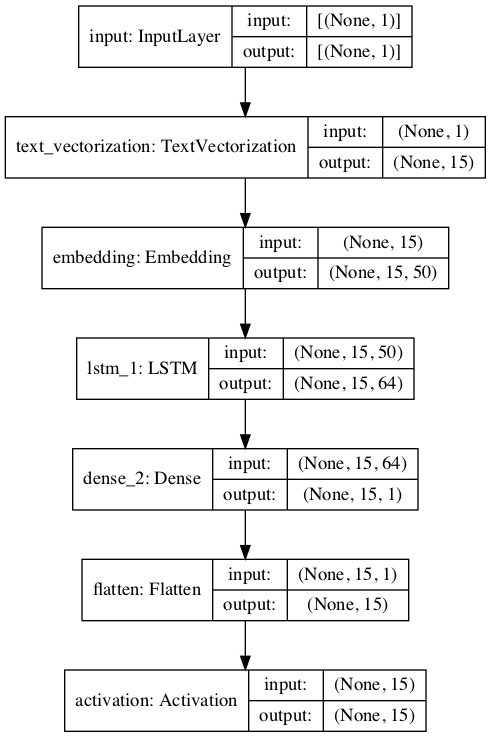

In [ ]:
# PLOT ATTENTION MODEL from classifier model with ATTENTION
attention_model = get_attention_model(model)
plot_model(
    attention_model,
    show_shapes=True,
    show_layer_names=True,
    to_file="model_get_attention.png",
)


In [ ]:
# ------------------------------------------------------
# GET ATTENTION
# ------------------------------------------------------
attentions = attention_model.predict(X_val[0])
attentions


array([[0.07253008, 0.0917171 , 0.06473119, 0.06196006, 0.06346381,
        0.0638293 , 0.0642563 , 0.064474  , 0.06460689, 0.06467967,
        0.06472068, 0.0647435 , 0.06475631, 0.06476352, 0.06476762]],
      dtype=float32)

In [ ]:
# ------------------------------------------------------
# GET ATTENTION for each WORD
# ------------------------------------------------------
from sklearn import preprocessing


def get_attention(X, y, prediction, attention, N=5):
    # normalize attention (without the padding part)
    normalized_attention = preprocessing.QuantileTransformer().fit_transform(attention)

    results = []
    for i, (X_, y_, p_, a_) in enumerate(zip(X, y, prediction, normalized_attention)):
        if i > N:
            break
        # build result
        result_entry = {}
        result_entry["prediction"] = (np.argmax(y_), np.argmax(p_))
        result_entry["original"] = np.asscalar(X_)
        result_entry["sentence"] = []
        for j, word in enumerate(vectorize_layer(X_).numpy().flatten().tolist()):
            word_obj = {}
            if word == 0:
                break
            word_obj[vectorize_layer.get_vocabulary()[word]] = a_[j].item()
            result_entry["sentence"].append(word_obj)

        results += [result_entry]
    return results


sentences_with_attention = get_attention(
    X_val, y_val, model.predict(X_val), attention_model.predict(X_val), 10
)
sentences_with_attention[0]


/var/folders/l4/ptzjj6dn0_x5trgl90dc98g40000gn/T/ipykernel_3030/2036900014.py:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  result_entry["original"] = np.asscalar(X_)


{'prediction': (0, 4),
 'original': 'Pretty good',
 'sentence': [{'[UNK]': 0.36486485600471497}, {'good': 0.9814814925193787}]}

In [ ]:
# convert prediction with attention to colored text
from termcolor import colored


def print_text(sentences_with_attention):
    threshold = 0.75
    classes = []
    print(colored("In green, the most important word\n\n", "green", attrs=["bold"]))

    for i, sentence in enumerate(sentences_with_attention):
        # Retrieve the class of this sentence
        # print(sentence)
        original_class, predicted_class = sentence["prediction"]
        # print(original_class, predicted_class)

        # Retrieve all the words and weights of this sentence
        words, weights = [], []
        # print("--", sentence['sentence'])
        for item in sentence["sentence"]:
            for word, weight in item.items():
                words.append(word)
                weights.append(float(weight))

        size = 0
        print(sentence["original"])
        for j, word in enumerate(words):
            if size != 0 and j != 0 and word != "," and word != ".":
                print(" ", end="")
            if weights[j] > threshold:
                print(colored(word, "green", attrs=["bold"]), end=" ")
            elif weights[j] < (1 - threshold):
                print(colored(word, "red", attrs=["bold"]), end=" ")
            else:
                print(colored(word, "grey"), end=" ")
            size += len(word) + 1
            if size > 80:
                print()
            size = 0

        print("\n")


print_text(sentences_with_attention)


In green, the most important word


Pretty good
[UNK] good 

Excellent,very good Very fast
[UNK] good very [UNK] 

This was a replacement. We had a POS Samsung from Cincinnati Bell. That phone was the worst thing we ever owned! This HTC seems to be built to last. It is small. Dont plan on rocking a lot of video. However, it is an Andriod and I think my wife likes it. It feels sturdy too. We bought it unlocked. All we had to do was insert the SIM card. It took about 2min to get it all set up. Very nice! I would give it 4-stars but the internal memory will eventually be an issue.
this was a [UNK] [UNK] had a [UNK] [UNK] from [UNK] [UNK] that phone was 

Was used ! Had to return it
was [UNK] had to [UNK] it 

Just loved the item, and it was just as the pictured stated, therefore i'm happy with my purchase, but i feel it being a Nokia it should of been able to do a bit more.
just [UNK] the [UNK] and it was just as the [UNK] [UNK] [UNK] [UNK] [UNK] 

total confianza y satisfacción el un pro

## Your work

<font color='red'>
<br>
TO DO Students
    
1. Before modifying the code, take the time to understand it well. We use here the global attentions mechanism only from an encoder since the network for sentiment analysis has no decoder part, only a classifier 1
    
1. Improve the f1 score for the **Attentional LSTM** model using BI-LSTM approach, better hyper-parameters and a better preprocessing (the same as in the previous step).
    * Take inspiration from the course slides to build an original architecture that you will describe
    * Use your Attention part in order to explain the words taken into account by the network to predict the sentiment.
    
1. **Upload on moodle**
    * **a clean, documented notebook** containing **your best LSTM attentional model**. The evaluation metric is the f1 score (macro avg).
    * You can build all sorts of architectures but only using the cells seen in class (i.e. in particular: **CNNs are not yet seen so you should not use them**).

    * It is of course possible / desirable to use keras tuner to get the best hyper-parameters.

    * This notebook will be evaluated and the grade will take into account the editorial quality of your text.

    * Any notebook containing more than 1 model will not be evaluated (score = 0 -> **You have to choose the best one**).

</font>


<font color='red'>


In [ ]:
# remember to remove the cut on the dataset which saves training time
